This notebook contains the code for data preview, preprocessing, filtering and format convertion


# Environment setup

In [1]:
LIB_DIR = '/home/yuning/Work/cs-273/src/'
import sys
if LIB_DIR not in sys.path:
    sys.path.insert(0, LIB_DIR)

import importlib
from pprint import pprint
from ref.atminter.lib.modules.paperparse import SpFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import util
import os
import glob

import matplotlib as mp
mp.rcParams['figure.dpi'] = 300

# Parse data from `.ann` file
## Code

In [2]:
class Abstract(object):

    def __init__(self, id, label=None, title=None, abstract=None):
        self.id = id
        if label is not None:
            self.label = label
        if title is not None:
            self.title = title
        if abstract is not None:
            self.abstract = abstract

class AnnData(object):

    def __init__(self, abs_list):
        self.dataset = abs_list
        pass
    
    @staticmethod
    def read_ann_file(file_dirc, ix=0):
        """function to read .ann file and convert to a list of Abstract objects
        """
        import os
        
        print('Load file {}...'.format(os.path.basename(file_dirc)))
        label_map = {
            'F': 0,
            'T': 1
        }
        
        dataset = []
        with open(file_dirc) as handle:
            while True:
                try:
                    label = next(handle)
                except StopIteration:
                    break  #EoF
                label = label_map[label[1].upper()]
                title = next(handle)
                if title[:4] == 'TI  ':
                    title = title[6:]
                if title[-1:] == '\n':
                    title = title[:-1]
                if title[0] == '[' and title[-1] == ']':
                    title = title[1:-1]
                abstract = next(handle)
                
                if abstract[:4] == 'AB  ':
                    abstract = abstract[6:]
                if abstract[-1:] == '\n':
                    abstract = abstract[:-1]
                if len(abstract) >= 2:
                    if abstract[0] == '[' and abstract[-1] == ']':
                        abstract = abstrac[1:-1]
                dataset.append(Abstract(id=ix, label=label, title=title, abstract=abstract))
                ix += 1
        return dataset    
    
    @classmethod
    def from_ann_file(cls, file_dirc):
        """Create a dataset from .ann file
        """
        
        dataset = cls.read_ann_file(file_dirc)
        return cls(dataset)
        
    def add_ann_file(self, file_dirc, inplace=True):
        import os
        """Append dataset with new .ann file"""
        
        self.dataset += self.read_ann_file(file_dirc)
    
    def overview(self):
        """Print out overview of dataset"""
        print('Dataset size: {}'.format(len(self.dataset)))
        print('Positive: {}\nNegative: {}'.format(
            len([1 for data in self.dataset if data.label == 1]),
            len([1 for data in self.dataset if data.label == 0])
        ))
        
    def train_dev_test_split(self, ratio=(0.8, 0.1, 0.1), random_state=23, save_dirc=None, ann=False):
        """Split dataset into train, dev, and test set.
        Export as .tsv file if applicable, otherwise return three split datasets
        """
        
        from sklearn.model_selection import train_test_split
        import os
        
        train = AnnData([])
        dev = AnnData([])
        test = AnnData([])
        train.dataset, test.dataset = train_test_split(self.dataset,
                                                       train_size=ratio[0], test_size=1 - ratio[0],
                                                       random_state=random_state,
                                                       stratify=[data.label for data in self.dataset])
        dev.dataset, test.dataset = train_test_split(test.dataset,
                                                     train_size=ratio[1]/(ratio[1] + ratio[2]),
                                                     test_size=ratio[2]/(ratio[1] + ratio[2]),
                                                     random_state=random_state,
                                                     stratify=[data.label for data in test.dataset])
        if save_dirc is not None:
            if not os.path.isdir(save_dirc):
                os.mkdir(save_dirc)
            if ann:
                train.to_ann(save_dirc + '/train.ann')
                dev.to_ann(save_dirc + '/dev.ann')
                test.to_ann(save_dirc + '/test.ann')
            else:
                train.to_tsv(save_dirc + '/train.tsv')
                dev.to_tsv(save_dirc + '/dev.tsv')
                test.to_tsv(save_dirc + '/test.tsv')
        else:
            return train, dev, test
    
    def KFold_split(self, k=10, save_data_to=None, ann=False):
        """Generate stratified K-Fold cross-validator
        """
        from sklearn.model_selection import StratifiedKFold
        import os
        
        SKFold = StratifiedKFold(n_splits=k, random_state=23, shuffle=True)
        
        if save_data_to:
            if not os.path.exists(save_data_to):
                os.makedirs(save_data_to)
        else:
            k_fold_buffer = []
        for set_ix, (train_index, test_index) in enumerate(SKFold.split(X=np.zeros(len(self.dataset)),
                                                                        y=[data.label
                                                                           for data in self.dataset])):
            data = np.array(self.dataset)
            train, dev = AnnData(data[train_index]), AnnData(data[test_index])
            print("--------------------set {}--------------------".format(set_ix))
            print(train.overview())
            print(dev.overview())
            if save_data_to:
                if not os.path.exists(save_data_to + '/set_{}'.format(set_ix + 1)):
                    os.makedirs(save_data_to + '/set_{}'.format(set_ix + 1))
                if ann:
                    train.to_ann(save_data_to + '/set_{}'.format(set_ix + 1) + '/train.ann')
                    dev.to_ann(save_data_to + '/set_{}'.format(set_ix + 1) + '/dev.ann')
                else:
                    train.to_tsv(save_data_to + '/set_{}'.format(set_ix + 1) + '/train.tsv')
                    dev.to_tsv(save_data_to + '/set_{}'.format(set_ix + 1) + '/dev.tsv')
                
            else:
                k_fold_buffer.append((train, dev))
        
        if not save_data_to:
            return k_fold_buffer
    
    def to_tsv(self, tsv_dirc, trunc_length=None):
        import os
        
        def trunc_text(text, trunc_length):
            """Deprecated
            """
            tokens = text.split()
            if len(tokens) > trunc_length:
                tokens = tokens[:trunc_length]
            return ' '.join(tokens)
        
        if not os.path.exists(tsv_dirc[:tsv_dirc.rfind('/')]):
            os.makedirs(tsv_dirc[:tsv_dirc.rfind('/')])
        
        with open(tsv_dirc, 'w') as handle:
            handle.write('id\ttext\n')
            for data in self.dataset:
                if trunc_length:
                    handle.write('{}\t{}\n'.format(data.label, trunc_text(data.abstract, trunc_length)))
                else:
                    handle.write('{}\t{}\n'.format(data.label, data.abstract))
                    
    def to_ann(self, ann_dirc):
        import os
        if not os.path.exists(ann_dirc[:ann_dirc.rfind('/')]):
            os.makedirs(ann_dirc[:ann_dirc.rfind('/')])
        
        with open(ann_dirc, 'w') as handle:
            label_map = {
                1: 'T',
                0: 'F'
            }
            for data in self.dataset:
                handle.write('>{}\n'.format(label_map[data.label]))
                handle.write('{}\n'.format(data.title))
                handle.write('{}\n'.format(data.abstract))

In [3]:
dataset = AnnData.from_ann_file(file_dirc='/home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/lactobacillus_acidophilus#escherichia_coli.ann')
dataset.add_ann_file(file_dirc='/home/yuning/Work/cs-273/src/ref/atminter/data/train_test_data/collated_train.ann')
dataset.overview()

Load file lactobacillus_acidophilus#escherichia_coli.ann...
Load file collated_train.ann...
Dataset size: 4145
Positive: 294
Negative: 3851


# Examine dataset
## Look at the length distribution of abstracts after tokenization of `WordPiece`
Length of tokenized abstract is important for BERT implementation

Length distribution on "words"


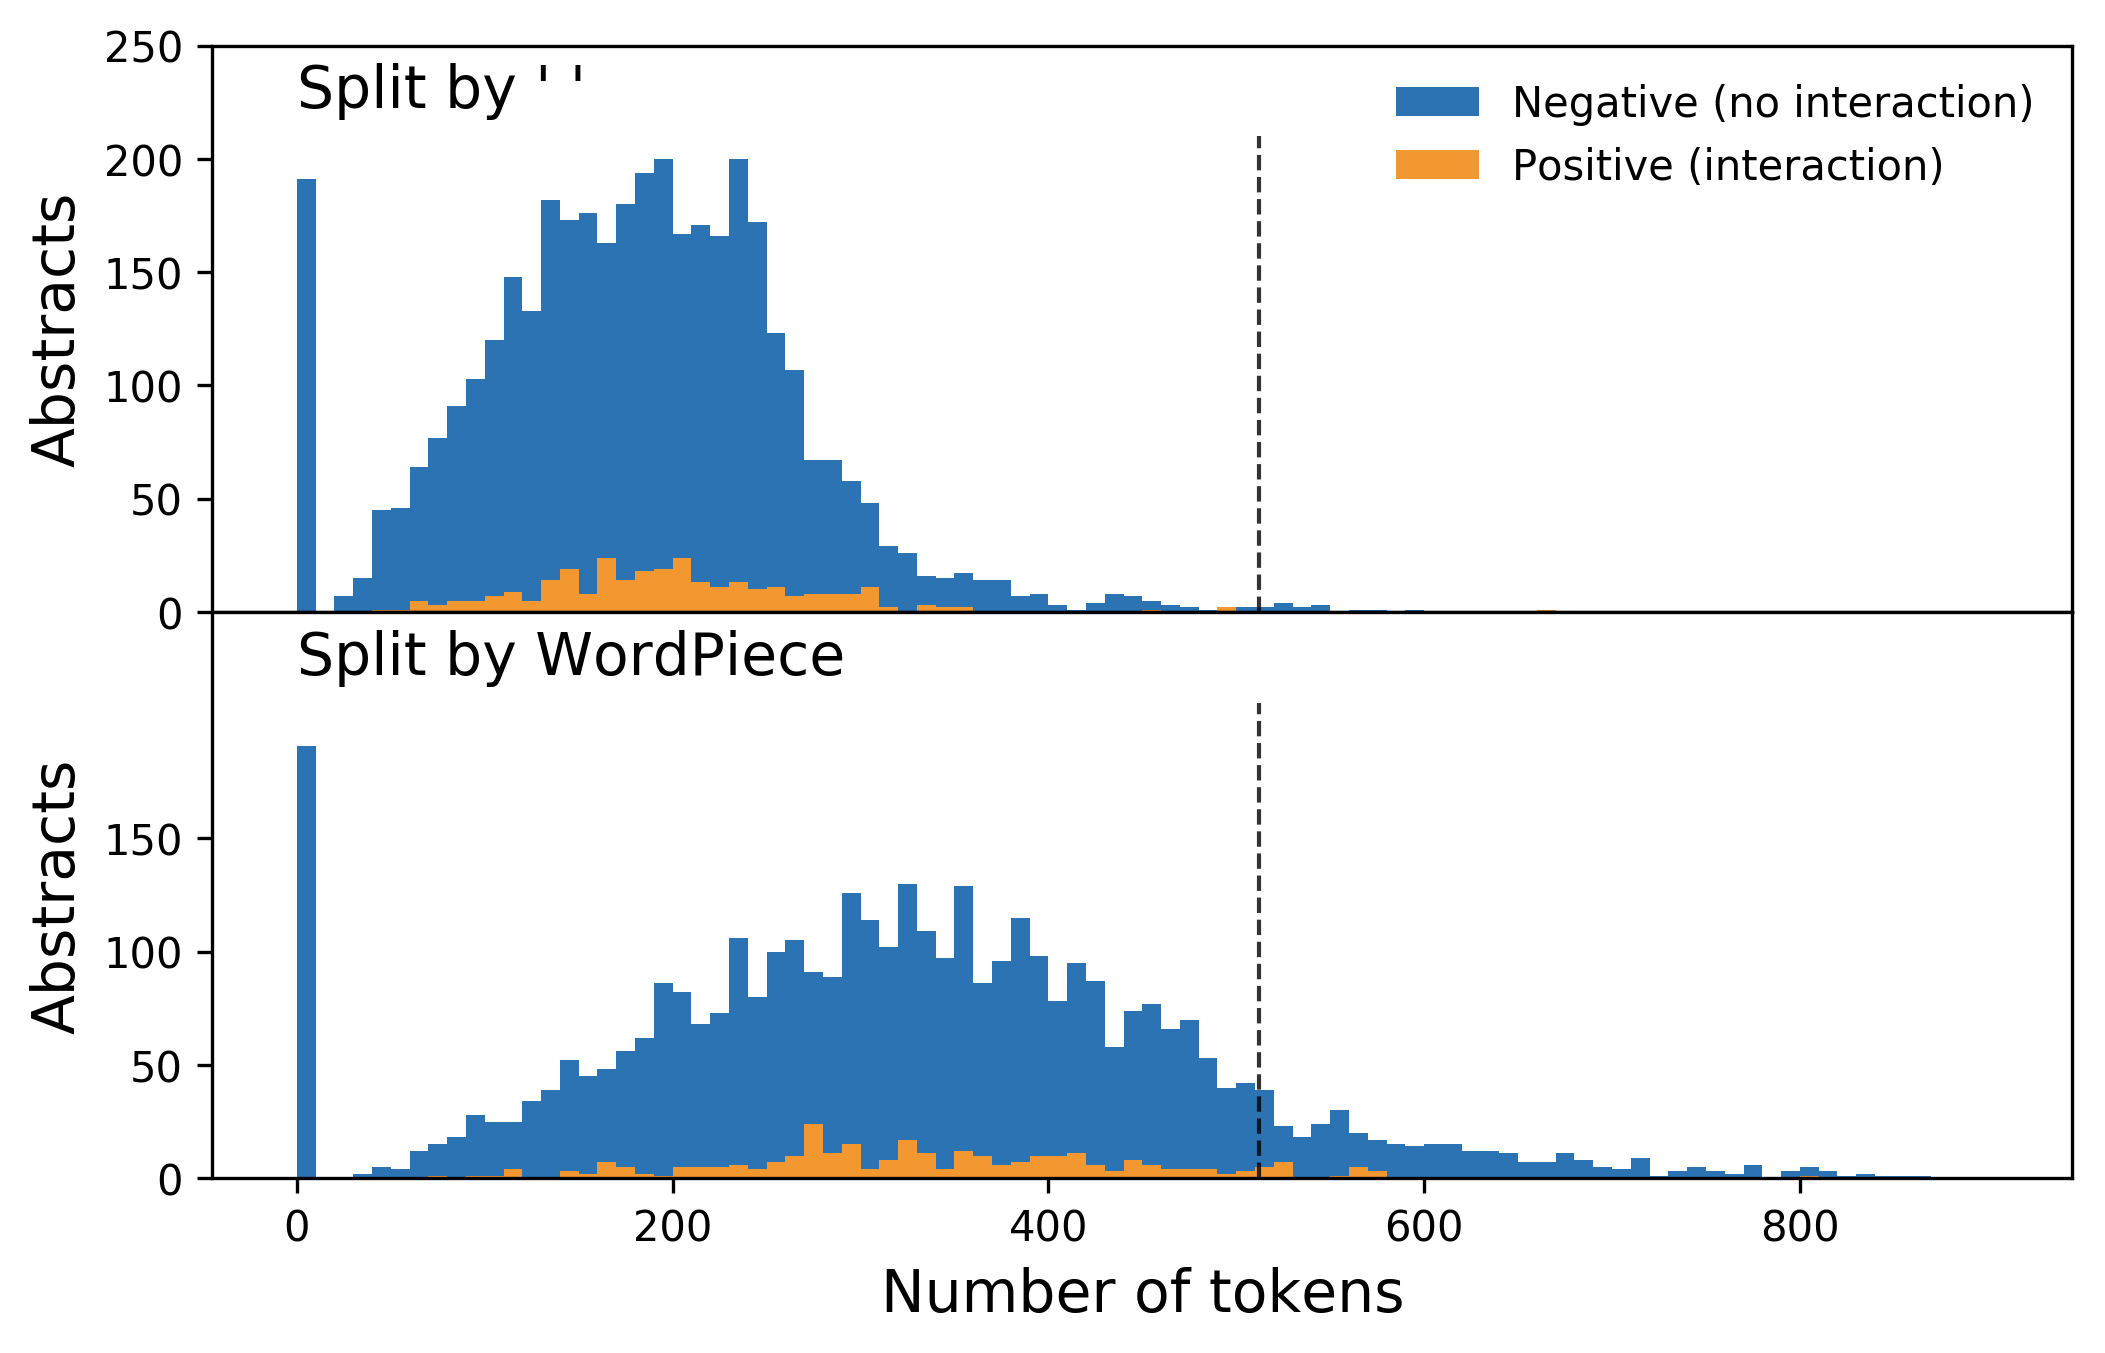

In [35]:
print(util.color.BOLD + util.color.BLUE + \
'Length distribution on "words"' + util.color.END) 

from ref.bert import tokenization
tokenizer = tokenization.FullTokenizer(vocab_file='/mnt/storage/projects/cs-273/bert_pretrained/uncased_L-12_H-768_A-12/vocab.txt')

# len_list = np.array([len(data.abstract.split()) for data in dataset.dataset])
# token_len_list = np.array([len(tokenizer.tokenize(data.abstract)) for data in dataset.dataset])
# label = np.array([data.label for data in dataset.dataset])

fig, axes = plt.subplots(2, 1, figsize=[8, 5], sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
bins = np.linspace(0, 900, 91)
axes[0].hist(len_list[label == 0], color='#2C73B4', bins=bins, label='Negative (no interaction)')
axes[0].hist(len_list[label == 1], color='#F39730', bins=bins, label='Positive (interaction)')
axes[0].set_ylabel('Abstracts', fontsize=14)
axes[0].plot([512, 512], [0, 210], 'k--', lw=1, alpha=0.8)
axes[0].text(s="Split by ' '", x=0, y=230, ha='left', va='center', fontsize=14)
axes[0].set_ylim([0, 250])
axes[0].legend(frameon=False)

axes[1].hist(token_len_list[label == 0], color='#2C73B4', bins=bins, label='Negative (no interaction)')
axes[1].hist(token_len_list[label == 1], color='#F39730', bins=bins, label='Positive (interaction)')
axes[1].set_xlabel("Number of tokens", fontsize=14)
axes[1].set_ylabel("Abstracts", fontsize=14)
axes[1].plot([512, 512], [0, 210], 'k--', lw=1, alpha=0.8)
axes[1].set_yticks([0, 50, 100, 150])
axes[1].set_ylim([0, 250])
axes[1].text(s="Split by WordPiece", x=0, y=230, ha='left', va='center', fontsize=14)

fig.savefig('/home/yuning/Work/cs-273/figs/token_dist.jpeg', bbox_inches='tight')
plt.show()

## Some sample words for tokenization


In [282]:
sample_words = [
    'Interaction',
    'inhibit',
    'inhibiting',
    'inhibition',
    'Escherichia coli',
    'Lactobacillus acidophilus',
    'L. acidophilus VTCC-B-871',
    'Lactic acid bacteria',
]
for word in sample_words:
    print('{} --> {}'.format(word, tokenizer.tokenize(word)))

Interaction --> ['interaction']
inhibit --> ['inhibit']
inhibiting --> ['inhibit', '##ing']
inhibition --> ['inhibition']
Escherichia coli --> ['es', '##cher', '##ichi', '##a', 'coli']
Lactobacillus acidophilus --> ['lac', '##to', '##ba', '##ci', '##llus', 'acid', '##op', '##hil', '##us']
L. acidophilus VTCC-B-871 --> ['l', '.', 'acid', '##op', '##hil', '##us', 'vt', '##cc', '-', 'b', '-', '87', '##1']
Lactic acid bacteria --> ['lac', '##tic', 'acid', 'bacteria']


## Print out some short sample for postive and negative text

In [285]:
counter = 0
for data in dataset.dataset:
    if (0 <= len(data.abstract.split()) < 200) and (data.label==1):
        print(data.label)
        print(data.abstract)
        counter += 1
    if counter >= 5:
        break

1
The aim of this study was to investigate the murein hydrolase activities of the surface layer proteins (SLPs) from two strains of Lactobacillus acidophilus using zymography. The influence of these hydrolase activities on Escherichia coli ATCC 43893 was also evaluated by analysing their growth curve, cell morphology and physiological state. After the incubation of E. coli with SLPs, growth was inhibited, the number of viable cells was significantly reduced, examination by transmission electron microscopy showed that the cell wall was damaged and flow cytometry results indicated that the majority of the cells were sublethally injured. All of these results suggested that the SLPs of both L. acidophilus strains possessed murein hydrolase activities that were sublethal to E. coli cells.
1
In this article, preparation and application characteristics of microencapsulated Lactobacillus acidophilus were investigated. Results indicated that the optimum condition for preparation of micro encaps

In [286]:
counter = 0
for data in dataset.dataset:
    if (0 <= len(data.abstract.split()) < 200) and (data.label==0):
        print(data.label)
        print(data.abstract)
        counter += 1
    if counter >= 5:
        break

0
Lactobacilli are widespread in natural environments and are increasingly being investigated as potential health modulators. In this study, we have adapted the broad-host-range vector pNZ8048 to express the mCherry protein (pRCR) to expand the usage of the mCherry protein for analysis of gene expression in Lactobacillus. This vector is also able to replicate in Streptococcus pneumoniae and Escherichia coli. The usage of pRCR as a promoter probe was validated in Lactobacillus acidophilus by characterizing the regulation of lactacin B expression. The results show that the regulation is exerted at the transcriptional level, with lbaB gene expression being specifically induced by co-culture of the L. acidophilus bacteriocin producer and the S. thermophilus STY-31 inducer bacterium.
0
For whole-cell aptamers selection, cells surface situation has great impact on single-stranded (ssDNA) binding and aptamers selection. In this work, both Lactobacillus acidophilus and Escherichia coli as well

## Print out some examples of too-long abstracts
We found that the first sentence of long abstract is usually a statement of background, thus, is safer to leave out without changing the suggestion of interaction or not

In [86]:
for data in dataset.dataset:
    if len(tokenizer.tokenize(data.abstract)) > 510:
        print(repr(data.abstract))

'Bacteria isolated from surgical infections during the period from April 2011 to March 2012 were investigated in a multicenter study in Japan, and the following results were obtained. In this series, 785 strains including 31 strains of Candida spp. were isolated from 204 (78.8%) of 259 patients with surgical infections. Five hundred and twenty three strains were isolated from primary infections, and 231 strains were isolated from surgical site infection. From primary infections, anaerobic Gram-negative bacteria were predominant, followed by aerobic Gram-negative bacteria, while from surgical site infection aerobic Gram-positive bacteria were predominant, followed by anaerobic Gram-negative bacteria. Among aerobic Gram-positive bacteria, the isolation rate of Enterococcus spp. was highest, followed by Streptococcus spp. and Staphylococcus spp., in this order, from primary infections, while Enterococcus spp. was highest, followed by Staphylococcus spp. from surgical site infection. Among

limit_output extension: Maximum message size of 10000 exceeded with 32811 characters

# Create dataset for training
## filter data that does not contain valid abstracts

In [4]:
# Filter
dataset_filered = AnnData(abs_list=[data for data in dataset.dataset if len(data.abstract.split())>5])

In [5]:
dataset_filered.overview()

Dataset size: 3954
Positive: 294
Negative: 3660


## Split dataset into train-dev-test set with ration [0.8, 0.1, 0.1]

In [116]:
dataset_filered.train_dev_test_split(random_state=23, ratio=(0.8, 0.1, 0.1), save_dirc='/mnt/storage/projects/cs-273/dataset/train_dev_test', ann=True)

## Split dataset using 5-Fold validation

In [117]:
dataset_filered.KFold_split(k=5, save_data_to='/mnt/storage/projects/cs-273/dataset/cross_validation', ann=True)

--------------------set 0--------------------
Dataset size: 3163
Positive: 235
Negative: 2928
None
Dataset size: 791
Positive: 59
Negative: 732
None
--------------------set 1--------------------
Dataset size: 3163
Positive: 235
Negative: 2928
None
Dataset size: 791
Positive: 59
Negative: 732
None
--------------------set 2--------------------
Dataset size: 3163
Positive: 235
Negative: 2928
None
Dataset size: 791
Positive: 59
Negative: 732
None
--------------------set 3--------------------
Dataset size: 3163
Positive: 235
Negative: 2928
None
Dataset size: 791
Positive: 59
Negative: 732
None
--------------------set 4--------------------
Dataset size: 3164
Positive: 236
Negative: 2928
None
Dataset size: 790
Positive: 58
Negative: 732
None
